# ChainerRL クイックスタートガイド

このNotebookは初めてChainerRLを試してみたいユーザーのためのクイックスタートガイドです。

以下のコマンドを実行してChainerRLをインストールします。

In [1]:
# Install Chainer, ChainerRL and CuPy!

!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80 chainer
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install chainerrl
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

Extracting templates from packages: 100%


まず、必要なモジュールをインポートする必要があります。 ChainerRLのモジュール名は `chainerrl`です。 後で使うので、 `gym`と` numpy`もインポートしましょう。

In [2]:
import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym
import numpy as np

/usr/local/lib/python3.6/dist-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


ChainerRLは、「環境」がモデル化されている場合、あらゆる問題に使用できます。 [OpenAI Gym](https://github.com/openai/gym) は、さまざまな種類のベンチマーク環境を提供し、それらの間の共通インターフェースを定義します。 ChainerRLはこのインタフェースのサブセットを使用します。 具体的には、環境はその状態空間(observation space)と行動空間(action space)を定義し、少なくとも2つのメソッド、 `reset`と` step`を持っていなければなりません。

- `env.reset` は、環境を初期状態にリセットし、最初の状態(observation)を返します。
- `env.step` は与えられたアクションを実行し、次の状態に移り、4つの値を返します：
   - 次の状態(observation)
   - 報酬(scalar reward)
   - 現在の状態が終了状態かどうかを示すブール値
   - 追加情報
- `env.render`は現在の状態をレンダリングします。

ここで、古典的な制御問題である CartPole-v0 を試してみましょう。 以下では、状態空間が4つの実数で構成され、その動作空間が2つの離散的なアクションで構成されていることが分かります。

In [3]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
#env.render()
print('initial observation:', obs)

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation space: Box(4,)
action space: Discrete(2)
initial observation: [-0.04055678 -0.00197163  0.02364212  0.03487198]
next observation: [-0.04059621 -0.1974245   0.02433956  0.33491948]
reward: 1.0
done: False
info: {}


これで、環境を定義しました。 次に、環境とのやり取りを通して学ぶエージェントを定義する必要があります。

ChainerRLはさまざまなエージェントを提供し、それぞれが深層強化学習アルゴリズムを実装しています。

[DQN(Deep Q-Network)](http://dx.doi.org/10.1038/nature14236)を使用するには、状態を受け取り、エージェントの各アクションが取りうる、将来の期待リターンを返すQ関数を定義する必要があります。 ChainerRLでは、Q関数を以下のように `chainer.Link`として定義することができます。 出力は `chainerrl.action_value.ActionValue`を実装する` chainerrl.action_value.DiscreteActionValue`によってラップされることに注意してください。 ChainerRLは、Q関数の出力をラップすることによって、このような離散アクションQ関数と[NAF(Normalized Advantage Functions)](https://arxiv.org/abs/1603.00748)を同様に扱うことができます。

In [0]:
class QFunction(chainer.Chain):

    def __init__(self, obs_size, n_actions, n_hidden_channels=50):
        super().__init__()
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_hidden_channels)
            self.l1 = L.Linear(n_hidden_channels, n_hidden_channels)
            self.l2 = L.Linear(n_hidden_channels, n_actions)

    def __call__(self, x, test=False):
        """
        Args:
            x (ndarray or chainer.Variable): An observation
            test (bool): a flag indicating whether it is in test mode
        """
        h = F.tanh(self.l0(x))
        h = F.tanh(self.l1(h))
        return chainerrl.action_value.DiscreteActionValue(self.l2(h))

obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
q_func = QFunction(obs_size, n_actions)

Chainerと同じようにCUDAを計算に使用する場合は、 `to_gpu`を呼び出します。

**Colaboratoryを使用する場合は、ランタイムタイプをGPUに変更する必要があります。**.


In [5]:
q_func.to_gpu(0)

ChainerRLの定義済みのQ関数を使用することもできます。

In [0]:
_q_func = chainerrl.q_functions.FCStateQFunctionWithDiscreteAction(
    obs_size, n_actions,
    n_hidden_layers=2, n_hidden_channels=50)

Chainerのように、 `chainer.Optimizer`はモデルの更新に使用されます。

In [0]:
# Use Adam to optimize q_func. eps=1e-2 is for stability.
optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)

Q関数とその最適化関数は、DQNのエージェントによって使用されます。 DQNのエージェントを作成するには、より多くのパラメータと設定を指定する必要があります。

In [0]:
# Set the discount factor that discounts future rewards.
gamma = 0.95

# Use epsilon-greedy for exploration
explorer = chainerrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.3, random_action_func=env.action_space.sample)

# DQN uses Experience Replay.
# Specify a replay buffer and its capacity.
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 6)

# Since observations from CartPole-v0 is numpy.float64 while
# Chainer only accepts numpy.float32 by default, specify
# a converter as a feature extractor function phi.
phi = lambda x: x.astype(np.float32, copy=False)

# Now create an agent that will interact with the environment.
agent = chainerrl.agents.DoubleDQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)

以上で、エージェントと環境の準備ができました。では、強化学習を始めましょう！

学習時は、 `agent.act_and_train`を使って探索行動を選択します。 エピソードの終了後に `agent.stop_episode_and_train`を呼び出さなければなりません。 `agent.get_statistics`を使ってエージェントのトレーニング統計を得ることができます。

In [9]:
n_episodes = 200
max_episode_len = 200
for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        # Uncomment to watch the behaviour
        # env.render()
        action = agent.act_and_train(obs, reward)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(obs, reward, done)
print('Finished.')

episode: 10 R: 37.0 statistics: [('average_q', 1.2150215711003933), ('average_loss', 0.05015367301912823)]
episode: 20 R: 44.0 statistics: [('average_q', 3.7857904640201947), ('average_loss', 0.09890545599011519)]
episode: 30 R: 97.0 statistics: [('average_q', 7.7720408907953145), ('average_loss', 0.12504807923600555)]
episode: 40 R: 56.0 statistics: [('average_q', 10.963194695758215), ('average_loss', 0.15639676991049656)]
episode: 50 R: 177.0 statistics: [('average_q', 14.237965547239822), ('average_loss', 0.23526638038745168)]
episode: 60 R: 145.0 statistics: [('average_q', 17.240442032833762), ('average_loss', 0.16206694621384216)]
episode: 70 R: 175.0 statistics: [('average_q', 18.511116289009692), ('average_loss', 0.18787805607905012)]
episode: 80 R: 57.0 statistics: [('average_q', 18.951395985384725), ('average_loss', 0.149411012387425)]
episode: 90 R: 200.0 statistics: [('average_q', 19.599694542558165), ('average_loss', 0.16107124308010012)]
episode: 100 R: 200.0 statistics: [

以上で、エージェントのトレーニングを終えました。このエージェントはどのくらいうまく学習がいっているでしょうか。`agent.act`と` agent.stop_episode`を使ってテストすることができます。 epsilon-greedy などの探査はここでは使われていません。

Colaboratryで実行するために、ダミーのXセッションを起動します。これは、env.render()を実行時に、画面を表示できる必要があるためです（Xセッションが必要です）。 
また、実行結果をNotebook上で確認するため、matplotlib のアニメーション機能を使って表示します。

In [0]:
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

test episode: 0 R: 200.0
test episode: 1 R: 200.0
test episode: 2 R: 200.0


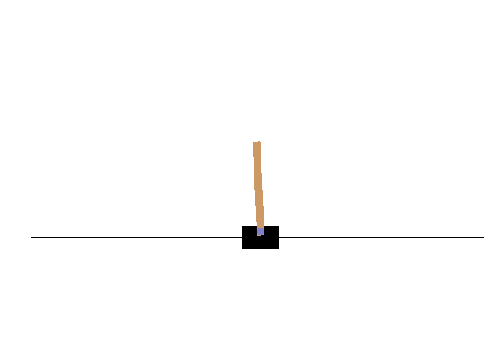

In [11]:
frames = []
for i in range(3):
    obs = env.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
    agent.stop_episode()
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

他に、OpenAI Gymの録画機能を使って、動画ファイルを作成することもできます。

In [0]:

# wrap env for recording video
envw = gym.wrappers.Monitor(env, "./", force=True)

for i in range(3):
    obs = envw.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        envw.render()
        action = agent.act(obs)
        obs, r, done, _ = envw.step(action)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
    agent.stop_episode()

test episode: 0 R: 200.0
test episode: 1 R: 200.0
test episode: 2 R: 200.0


Colaboratoryのダウンロード機能を使ってダウンロードします。
Episode毎に録画されるため、複数ファイル、ダウンロードされる事があります。

In [0]:
from google.colab import files
import glob

for file in glob.glob("openaigym.video.*.mp4"):
  files.download(file)

Colaboratory上の動画ファイルは削除しておきましょう。

In [0]:
!rm openaigym.video.*

以上のテストのスコアや実行結果が十分であれば、残りの作業はエージェントを保存して、再利用できるようにすることです。 これは、`agent.save`を呼び出してエージェントを保存し、次に保存したエージェントをロードするために`agent.load`を呼び出すだけです。

In [0]:
# Save an agent to the 'agent' directory
agent.save('agent')

# Uncomment to load an agent from the 'agent' directory
# agent.load('agent')

以上で、強化学習が学習・テストができました。

しかし、強化学習を実装するたびにこのようなコードを書くのは面倒かもしれません。 そのため、ChainerRLはこれらのことをするユーティリティ関数を持っています。

In [0]:
# Set up the logger to print info messages for understandability.
import logging
import sys
gym.undo_logger_setup()  # Turn off gym's default logger settings
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')

chainerrl.experiments.train_agent_with_evaluation(
    agent, env,
    steps=2000,           # Train the agent for 2000 steps
    eval_n_runs=10,       # 10 episodes are sampled for each evaluation
    max_episode_len=200,  # Maximum length of each episodes
    eval_interval=1000,   # Evaluate the agent after every 1000 steps
    outdir='result')      # Save everything to 'result' directory

ChainerRLクイックスタートガイドは以上です。 ChainerRLについてもっと知るには、 `examples`ディレクトリを見て、例を読んで実行してください。
ありがとうございました！